In [1]:
from torchvision.datasets import FashionMNIST

fashion_train = FashionMNIST(
    root="data/fmnist",
    download=True,
)
fashion_test = FashionMNIST(root="data/fmnist", train=False)

In [2]:
train_data = fashion_train.data
train_labels = fashion_train.targets

test_data = fashion_train.data
test_labels = fashion_train.targets

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def normalize(images):

    histograms = np.apply_along_axis(
        np.bincount, 1, images.reshape(images.shape[0], -1), minlength=256
    )

    cdf = histograms.cumsum(axis=1)
    cdf_min = cdf[:, 0][
        :, None
    ]  # Minimum of the CDF (first non-zero element in each row)

    # Normalize the CDF for each image
    cdf_m = ((cdf - cdf_min) * 255) / (cdf.max(axis=1)[:, None] - cdf_min)
    
    cdf_m = cdf_m.astype(np.uint8)

    idx = np.arange(images.shape[0])

    # Apply normalized CDF to each image
    normalized_images = cdf_m[np.arange(images.shape[0])[:,None,None], images] #  Broadcasting across images and index

    return normalized_images

In [5]:
train_norm = normalize(train_data)

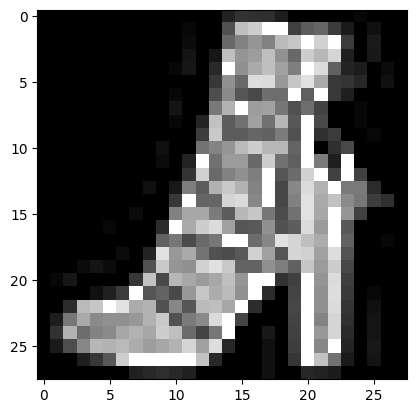

In [6]:
plt.imshow(train_norm[11],cmap="gray")